In [83]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
% matplotlib inline

In [4]:
#Tests to see if there is a collision between two pool balls
#Input: Position vectors, velocity vectors, timestep dt
#Output: True or False

def collision_detection_bb(r1,r2,v1,v2,dt):
    r1_f = r1 + v1*dt
    r2_f = r2 + v2*dt
    
    r_f = np.abs(r1_f - r2_f)
    r = np.sqrt(np.dot(r_f,r_f))
    
    if r < 2*R:
        return True
    else:
        return False

hey


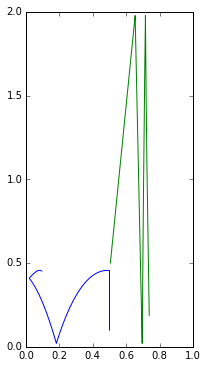

In [95]:
R = .02
g = 9.8
muSlip = .25
muRoll = .3
muWall = .15
muSpin = .15
x0a = .5
y0a = .1
z0a = 0
vx0a = 0.01
vy0a = 6.
vz0a = 0
wx0a = 400
wy0a = 0
wz0a = 0.01
x0b = .505
y0b = .5
z0b = 0
vx0b = 0.01
vy0b = 0.01
vz0b = 0
wx0b = 0
wy0b = 0
wz0b = 0.01
Table_x = 1
Table_y = 2

def cd_b_left(x,vx,dt):
    xf = x + vx*dt
     
    if xf < R:
        return True
    else:
        return False
    
def cd_b_right(x,vx,dt):
    xf = x + vx*dt
    if Table_x - xf < R:
        return True
    else:
        return False
    
def cd_b_back(y,vy,dt):
    yf = y + vy*dt  
    if Table_y - yf < R:
        return True
    else:
        return False
    
def cd_b_front(y,vy,dt):
    yf = y + vy*dt
    if yf < R:
        return True
    else:
        return False

def reflection_trans(b,vtang,R):
    
    if vtang == 2:
        vTangArray = np.array([b[vtang],0,0])
        vNormArray = np.array([0,b[3],0])
    else:
        vTangArray = np.array([0,b[vtang],0])
        vNormArray = np.array([b[2],0,0])
    
    wArray = np.array([b[5],b[6],b[7]])
    
    vSlip = vTangArray + np.cross(wArray,R)
    vSlipHat = vSlip/np.sqrt(np.dot(vSlip,vSlip))
    absvNorm = np.sqrt(np.dot(vNormArray,vNormArray))
    absvSlip = np.sqrt(np.dot(vSlip,vSlip))
    delvFric = np.array([0,0,0])
    if absvSlip < absvNorm:
        delvFric = muWall* absvSlip*absvNorm*-vSlipHat
    else:
        delvFric = muWall*absvNorm*absvNorm*-vSlipHat
    delv = np.array([delvFric[0] - 2*vNormArray[0],delvFric[1] - 2*vNormArray[1],0])
    
    delw = np.cross(R,delvFric)
    
    return np.array([b[2] + delv[0], b[3] + delv[1], b[4] + delv[2], b[5] + delw[0], b[6] + delw[1], b[7] + delw[2]])
    
#ball collisions were estimated to be elastic due to inability to figure out spin transfer    
def elastic_collision(r1,r2,v1,v2):
    Rc = r2 - r1
    Rchat = Rc/np.sqrt(np.dot(Rc,Rc))
    v1n = Rchat*np.dot(v1,Rchat)
    v1t = v1 - v1n
    v2n = -Rchat*np.dot(v2,-Rchat)
    v2t = v2 - v2n
    #balls keep their tangent velocities and swap normal velocities
    v1f = v2n + v1t
    v2f = v1n + v2t
    
    return np.array([v1f,v2f])






    
    


#                  0  1  2   3   4   5   6   7
inita = np.array([x0a,y0a,vx0a,vy0a,vz0a,wx0a,wy0a,wz0a])
initb = np.array([x0b,y0b,vx0b,vy0b,vz0b,wx0b,wy0b,wz0b])

def is_rolling(v,w):
    slipv = v + R*np.cross(np.array([0,0,1]),w)
    absslipv = np.sqrt(np.dot(slipv,slipv))
    if absslipv < .01:
        print "rolling"
    elif absslipv >= .01:
        print "slipping"

def pool_solver(init1, init2, t):
    
  
    
    dt = t[1]-t[0]
    a = np.zeros(shape = (len(t),8))
    b = np.zeros(shape = (len(t),8))
    a[0] = init1
    b[0] = init2
    Rollb = False #booleans used in attempt to implement rolling friction; serious problems encountered on that front
    Rolla = False
    vRoll = np.array([0,0,0])
    wRoll = np.array([0,0,0])
    for i in range(1, len(t)):
        xb = b[i-1,0]
        yb = b[i-1,1]
        vxb = b[i-1,2]
        vyb = b[i-1,3]
        vzb = b[i-1,4]
        wxb = b[i-1,5]
        wyb = b[i-1,6]
        wzb = b[i-1,7]
        
        #we're gonna need some vectors
        xhat = np.array([1,0,0])
        yhat = np.array([0,1,0])
        zhat = np.array([0,0,1])
        vb = np.array([vxb,vyb,vzb])
        vabsb = np.sqrt(np.dot(vb,vb))
        wb = np.array([wxb,wyb,wzb])
    
        #sliding velocity (any component of the velocity that isn't countered by the roll of the ball)
        ub = vb + R*np.cross(zhat,wb)
        uhatb = ub/np.sqrt(np.dot(ub,ub))
        absub = np.sqrt(np.dot(ub,ub))
        wzbabs = np.sqrt(wzb*wzb)
        wzbhat = wzb/np.sqrt(np.dot(wzb,wzb))
        if Rollb and vabsb > .02:
            
            vRollhatb = vb/np.sqrt(np.dot(vb,vb))
            dvRollb = -5.*muRoll*g*vRollhatb/7.
            wRollhatb = wb/np.sqrt(np.dot(wb,wb))
            dwRollb = -5.*muRoll*g*wRollhatb/(7.*R)
            dxb = vxb
            dyb = vyb
            dvxb = dvRollb[0]
            dvyb = dvRollb[1]
            dvzb = 0
            dwxb = dwRollb[0]
            dwyb = dwRollb[1]
            dwzb = dwRollb[2]
            if wzbabs > .02:
                dwzb = -wzbhat*g*muSpin
            
        
        if Rollb == False:
            
            dvSlipb = -muSlip*g*uhatb
            dwSlipb = np.cross(zhat,uhatb)*g*muSlip*5/(2*R)
            dxb = vxb
            dyb = vyb
            dvxb = dvSlipb[0]
            dvyb = dvSlipb[1]
            dvzb = 0
            dwxb = dwSlipb[0]
            dwyb = dwSlipb[1]
            dwzb = dwSlipb[2]
            if wzbabs > .02:
                dwzb = -wzbhat*g*muSpin
             
            if absub < .01:
                Rollb = True
                wRollb = np.array([wxb,wyb,wzb])
                vRollb = np.cross(np.array([0,0,-R]),wRollb)
                vxb = vRollb[0]
                vyb = vRollb[1]
                vzb = vRollb[2]
                
        
        elif Rollb and vabsb <= .02:
            
            dxb = 0
            dyb = 0
            dvxb = 0
            dvyb = 0
            dvzb = 0
            dwxb = 0
            dwyb = 0
            dwzb = 0
            
        
        b[i,0] = xb + dt*dxb
        b[i,1] = yb + dt*dyb
        b[i,2] = vxb + dt*dvxb
        b[i,3] = vyb + dt*dvyb
        b[i,4] = vzb + dt*dvzb
        b[i,5] = wxb + dt*dwxb
        b[i,6] = wyb + dt*dwyb
        b[i,7] = wzb + dt*dwzb
        
        
        if cd_b_right(b[i,0],b[i,2],dt):
            Rr = np.array([R,0,0])
            b[i,2] = reflection_trans(b[i],1,Rr)[0]
            b[i,3] = reflection_trans(b[i],1,Rr)[1]
            b[i,4] = reflection_trans(b[i],1,Rr)[2]
            b[i,5] = reflection_trans(b[i],1,Rr)[3]
            b[i,6] = reflection_trans(b[i],1,Rr)[4]
            b[i,7] = reflection_trans(b[i],1,Rr)[5]
            Rollb = False
        if cd_b_left(b[i,0],b[i,2],dt):
            Rl = np.array([-R,0,0])
            b[i,2] = reflection_trans(b[i],1,Rl)[0]
            b[i,3] = reflection_trans(b[i],1,Rl)[1]
            b[i,4] = reflection_trans(b[i],1,Rl)[2]
            b[i,5] = reflection_trans(b[i],1,Rl)[3]
            b[i,6] = reflection_trans(b[i],1,Rl)[4]
            b[i,7] = reflection_trans(b[i],1,Rl)[5] 
            Rollb = False
        if cd_b_back(b[i,1],b[i,3],dt):
            Rb = np.array([0,R,0])
            b[i,2] = reflection_trans(b[i],2,Rb)[0]
            b[i,3] = reflection_trans(b[i],2,Rb)[1]
            b[i,4] = reflection_trans(b[i],2,Rb)[2]
            b[i,5] = reflection_trans(b[i],2,Rb)[3]
            b[i,6] = reflection_trans(b[i],2,Rb)[4]
            b[i,7] = reflection_trans(b[i],2,Rb)[5]
            Rollb = False
        if cd_b_front(b[i,1],b[i,3],dt):
            Rf = np.array([0,-R,0])
            b[i,2] = reflection_trans(b[i],2,Rf)[0]
            b[i,3] = reflection_trans(b[i],2,Rf)[1]
            b[i,4] = reflection_trans(b[i],2,Rf)[2]
            b[i,5] = reflection_trans(b[i],2,Rf)[3]
            b[i,6] = reflection_trans(b[i],2,Rf)[4]
            b[i,7] = reflection_trans(b[i],2,Rf)[5]
            Rollb = False
            
        xa = a[i-1,0]
        ya = a[i-1,1]
        vxa = a[i-1,2]
        vya = a[i-1,3]
        vza = a[i-1,4]
        wxa = a[i-1,5]
        wya = a[i-1,6]
        wza = a[i-1,7]
        
        #we're gonna need some vectors
        xhat = np.array([1,0,0])
        yhat = np.array([0,1,0])
        zhat = np.array([0,0,1])
        va = np.array([vxa,vya,vza])
        vabsa = np.sqrt(np.dot(va,va))
        wa = np.array([wxa,wya,wza])
    
        #sliding velocity (any component of the velocity that isn't countered by the roll of the ball)
        ua = va + R*np.cross(zhat,wa)
        uhata = ua/np.sqrt(np.dot(ua,ua))
        absua = np.sqrt(np.dot(ua,ua))
        wzaabs = np.sqrt(wza*wza)
        wzahat = wza/np.sqrt(np.dot(wza,wza))
        if Rolla and vabsa > .02:
            
            vRollhata = va/np.sqrt(np.dot(va,va))
            dvRolla = -5.*muRoll*g*vRollhata/7.
            wRollhata = wa/np.sqrt(np.dot(wa,wa))
            dwRolla = -5.*muRoll*g*wRollhata/(7.*R)
            dxa = vxa
            dya = vya
            dvxa = dvRolla[0]
            dvya = dvRolla[1]
            dvza = 0
            dwxa = dwRolla[0]
            dwya = dwRolla[1]
            dwza = dwRolla[2]
            if wzaabs > .02:
                dwza = -wzahat*g*muSpin
            
        
        elif Rolla == False:
            
            dvSlipa = -muSlip*g*uhata
            dwSlipa = np.cross(zhat,uhata)*g*muSlip*5/(2*R)
            dxa = vxa
            dya = vya
            dvxa = dvSlipa[0]
            dvya = dvSlipa[1]
            dvza = 0
            dwxa = dwSlipa[0]
            dwya = dwSlipa[1]
            dwza = dwSlipa[2]
            if wzbabs > .02:
                dwza = -wzahat*g*muSpin
             
            if absua < .01:
                Rolla = True
                wRolla = np.array([wxa,wya,wza])
                vRolla = np.cross(np.array([0,0,-R]),wRolla)
                vxa = vRolla[0]
                vya = vRolla[1]
                vza = vRolla[2]
                
        
        elif Rolla and vabsa <= .02:
           
            dxa = 0
            dya = 0
            dvxa = 0
            dvya = 0
            dvza = 0
            dwxa = 0
            dwya = 0
            dwza = 0
            
        
        a[i,0] = xa + dt*dxa
        a[i,1] = ya + dt*dya
        a[i,2] = vxa + dt*dvxa
        a[i,3] = vya + dt*dvya
        a[i,4] = vza + dt*dvza
        a[i,5] = wxa + dt*dwxa
        a[i,6] = wya + dt*dwya
        a[i,7] = wza + dt*dwza
        
        
        if cd_b_right(a[i,0],a[i,2],dt):
            Rr = np.array([R,0,0])
            a[i,2] = reflection_trans(a[i],1,Rr)[0]
            a[i,3] = reflection_trans(a[i],1,Rr)[1]
            a[i,4] = reflection_trans(a[i],1,Rr)[2]
            a[i,5] = reflection_trans(a[i],1,Rr)[3]
            a[i,6] = reflection_trans(a[i],1,Rr)[4]
            a[i,7] = reflection_trans(a[i],1,Rr)[5]
            Rolla = False
        if cd_b_left(a[i,0],a[i,2],dt):
            Rl = np.array([-R,0,0])
            a[i,2] = reflection_trans(a[i],1,Rl)[0]
            a[i,3] = reflection_trans(a[i],1,Rl)[1]
            a[i,4] = reflection_trans(a[i],1,Rl)[2]
            a[i,5] = reflection_trans(a[i],1,Rl)[3]
            a[i,6] = reflection_trans(a[i],1,Rl)[4]
            a[i,7] = reflection_trans(a[i],1,Rl)[5] 
            Rolla = False
        if cd_b_back(a[i,1],a[i,3],dt):
            Rb = np.array([0,R,0])
            a[i,2] = reflection_trans(a[i],2,Rb)[0]
            a[i,3] = reflection_trans(a[i],2,Rb)[1]
            a[i,4] = reflection_trans(a[i],2,Rb)[2]
            a[i,5] = reflection_trans(a[i],2,Rb)[3]
            a[i,6] = reflection_trans(a[i],2,Rb)[4]
            a[i,7] = reflection_trans(a[i],2,Rb)[5]
            Rolla = False
        if cd_b_front(a[i,1],a[i,3],dt):
            Rf = np.array([0,-R,0])
            a[i,2] = reflection_trans(a[i],2,Rf)[0]
            a[i,3] = reflection_trans(a[i],2,Rf)[1]
            a[i,4] = reflection_trans(a[i],2,Rf)[2]
            a[i,5] = reflection_trans(a[i],2,Rf)[3]
            a[i,6] = reflection_trans(a[i],2,Rf)[4]
            a[i,7] = reflection_trans(a[i],2,Rf)[5]
            Rolla = False
        
        pl = np.array([a[i,0],a[i,1]])
        pk = np.array([b[i,0],b[i,1]])
        ls = np.array([a[i,2],a[i,3]])
        lk = np.array([b[i,2],b[i,3]])
        
        if collision_detection_bb(pl,pk,ls,lk,dt):
            print "hey"
            new_vs = elastic_collision(pl,pk,ls,lk)
            a[i,2] = new_vs[0,0]
            a[i,3] = new_vs[0,1]
            b[i,2] = new_vs[1,0]
            b[i,3] = new_vs[1,1]
        
   #     is_rolling(np.array([a[i,2],a[i,3],a[i,4]]),np.array([a[i,5],a[i,6],a[i,7]]))
    return np.array([a,b])
#always iterate at least 1000 times per second        
t = np.linspace(0,10,10001)

pool = pool_solver(inita,initb,t)

np.set_printoptions(threshold='nan')                              

plt.figure(figsize = (3,6))
plt.xlim(0,1)
plt.ylim(0,2)
plt.plot(pool[0,:,0],pool[0,:,1])
plt.plot(pool[1,:,0],pool[1,:,1])

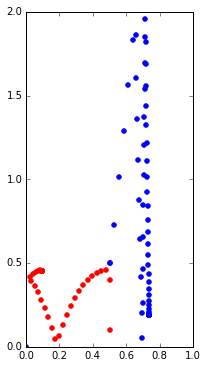

In [106]:
N = 200

xball1 = np.zeros([N+1])
yball1 = np.zeros([N+1])
xball2 = np.zeros([N+1])
yball2 = np.zeros([N+1])
for i in range(0,N):
    xball1[i] = pool[0,(10000/N)*i,0]
    yball1[i] = pool[0,(10000/N)*i,1]
    xball2[i] = pool[1,(10000/N)*i,0]
    yball2[i] = pool[1,(10000/N)*i,1]
    
plt.figure(figsize = (3,6))
plt.xlim(0,1)
plt.ylim(0,2)
plt.scatter(xball1,yball1,color = 'r')
plt.scatter(xball2,yball2,color = 'b')
    
    
    

In [ ]:
x0a = .5
y0a = .1
z0a = 0
vx0a = 0.01
vy0a = 6.
vz0a = 0
wx0a = 400
wy0a = 0
wz0a = 0.01
x0b = .505
y0b = .5
z0b = 0
vx0b = 0.01
vy0b = 0.01
vz0b = 0
wx0b = 0
wy0b = 0
wz0b = 0.01

initc = np.array([x0a,y0a,vx0a,vy0a,vz0a,wx0a,wy0a,wz0a])
initd = np.array([x0b,y0b,vx0b,vy0b,vz0b,wx0b,wy0b,wz0b])